# Deep Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Masking
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping

import joblib

Check si corre en Colab

In [3]:
try:
    DRIVE = True
    from google.colab import files
except ModuleNotFoundError:
    DRIVE = False

In [4]:
if DRIVE:
    #from google.colab import drive
    #drive.mount('/content/drive')
    #uploaded = files.upload()
    #for fn in uploaded.keys():
    #    print('User uploaded file "{name}" with length {length} bytes'.format(
    #        name=fn, length=len(uploaded[fn])))
    data = pd.read_csv('data.csv')
else:
    data = pd.read_csv('../../cyberbullying/data/all_df.csv')

In [5]:
percentage_used = 1
data = data.sample(frac=percentage_used, random_state=0)

In [6]:
data['text']=data['text'].astype(str)
data.loc[:,'target'] = pd.to_numeric(data.loc[:,'target'], downcast='integer')

data.head()

,text,target
211466,gdc was great today thank you for letting me b...,0
133440,image requested in collin county texas of head...,0
117920,jump on the bandwagon plenty of room amazing h...,0
145633,mesling i ve raised the matter at wikipedia so...,0
190951,in fact my recent work here at pinky ring show...,0


In [7]:
def load_data(percentage_of_sentences=None):
    
    X_train, X_test, y_train, y_test = train_test_split(data['text'],data['target'],test_size=0.3,random_state=0)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(X_train))
        X_train, y_train = X_train[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(X_test))
        X_test, y_test = X_test[:len_test], y_test[:len_test]
    
    #X_train = [text_to_word_sequence(_) for _ in X_train]
    #X_test = [text_to_word_sequence(_) for _ in X_test]
    
    X_train = X_train.map(text_to_word_sequence)
    X_test = X_test.map(text_to_word_sequence)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=100)

### Balanceo el dataset

In [8]:
def balance_df(X, y, ratio=0.3):
    df = pd.DataFrame({'text': X, 'target': y})
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    df_class_1_len = df_class_1.shape[0]
    
    df_class_0_new = df_class_0.sample(int(df_class_1_len * (1-ratio)/ratio))
    df_new = pd.concat([df_class_0_new, df_class_1]).sample(frac=1).reset_index(drop=True)
    
    X = df_new['text']
    y = df_new['target']

    return X, y

X_train, y_train = balance_df(X_train,y_train)

In [9]:
# Size of your embedding space = size to represent each word
embedding_size = 32

In [10]:
if DRIVE:
    word2vec = Word2Vec(sentences=X_train, size=embedding_size, window=5, min_count=5) # colab
else:
    word2vec = Word2Vec(sentences=X_train, vector_size=embedding_size, window=5, min_count=5) # jupyter

In [11]:
comm_1 = word2vec.wv.most_similar('asshole')
comm_1

[('cunt', 0.9658656120300293),
 ('fat', 0.9505540132522583),
 ('twat', 0.9450672268867493),
 ('faggot', 0.9417385458946228),
 ('retard', 0.940604031085968),
 ('prick', 0.9397361278533936),
 ('nigger', 0.9244213104248047),
 ('bitch', 0.9224582314491272),
 ('ignorant', 0.9161723852157593),
 ('dick', 0.9155343174934387)]

In [12]:
if DRIVE:
    vocab_size = len(word2vec.wv.vocab.keys()) # colab
else:
    vocab_size = len(word2vec.wv.key_to_index) # jupyter
vocab_size

8595

In [13]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

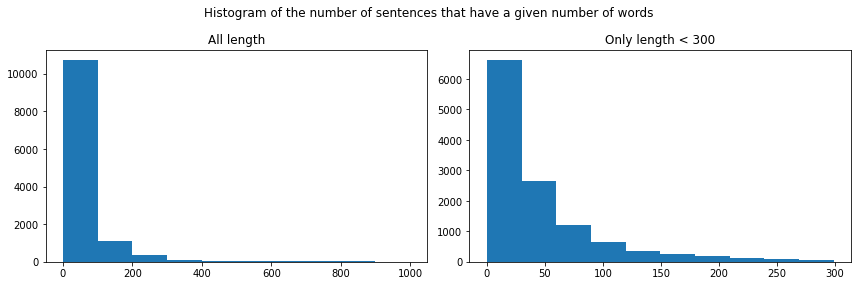

In [14]:
import matplotlib.pyplot as plt

def plot_hist(X):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    len_ = [len(_) for _ in X]
    ax1.hist(len_)
    ax1.set_title('All length')
    
    len_2 = [len(_) for _ in X if len(_) < 300]
    ax2.hist(len_2)
    ax2.set_title('Only length < 300')
    
    plt.suptitle('Histogram of the number of sentences that have a given number of words')
    plt.tight_layout(pad=1)
    plt.show()
    
plot_hist(X_train_embed)

In [15]:
# Pad the training and test embedded sentences
maxlen = 100
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=maxlen)

In [16]:
X_train_pad.shape

(12510, 100, 32)

In [17]:
X_test_pad.shape

(13646, 100, 32)

In [18]:
# TEST ME
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

In [19]:
input_shape = (maxlen,embedding_size)

# Deep Learning Models 

In [20]:
es = EarlyStopping(patience=5, restore_best_weights=True)

In [21]:
def print_metrics(result):
    for metric, value in zip(['Loss', 'Accuracy', 'Recall', 'Precision'], result):
        print(f'{metric}: {value:.2f}')

## SimpleRNN Model

## LSTM Model

## GRU Model

Best base model: GRU

## Tunning GRU Model

### 

In [22]:
def init_model_gru_3():

    model = Sequential()
    
    model.add(Masking(mask_value=0, input_shape=input_shape))
    
    model.add(LSTM(16, activation='tanh'))
    
    model.add(Dense(10, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', Recall(), Precision()])
    
    model.summary()
    
    return model

model_gru_3 = init_model_gru_3()

2022-03-12 19:27:15.455769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-12 19:27:15.468339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-03-12 19:27:15.471128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-12 19:27:15.472192: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Li

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 100, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,317
Trainable params: 3,317
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
history_gru_3 = model_gru_3.fit(X_train_pad, y_train, validation_split=0.3, callbacks=es, verbose=1, batch_size=32, epochs=100)

Epoch 1/100
137/137 [==============================] - 23s 131ms/step - loss: 0.5125 - accuracy: 0.7624 - recall: 0.4742 - precision: 0.6427 - val_loss: 0.4376 - val_accuracy: 0.7922 - val_recall: 0.5882 - val_precision: 0.6725
Epoch 2/100
137/137 [==============================] - 16s 114ms/step - loss: 0.4213 - accuracy: 0.8051 - recall: 0.6457 - precision: 0.6877 - val_loss: 0.4138 - val_accuracy: 0.8058 - val_recall: 0.6885 - val_precision: 0.6687
Epoch 3/100
137/137 [==============================] - 15s 109ms/step - loss: 0.3998 - accuracy: 0.8156 - recall: 0.6597 - precision: 0.7078 - val_loss: 0.3943 - val_accuracy: 0.8137 - val_recall: 0.6267 - val_precision: 0.7128
Epoch 4/100
137/137 [==============================] - 15s 107ms/step - loss: 0.3855 - accuracy: 0.8206 - recall: 0.6631 - precision: 0.7190 - val_loss: 0.3888 - val_accuracy: 0.8193 - val_recall: 0.6141 - val_precision: 0.7353
Epoch 5/100
137/137 [==============================] - 15s 112ms/step - loss: 0.3744 - a

In [24]:
res_gru_3 = model_gru_3.evaluate(X_test_pad, y_test, verbose=1)
print_metrics(res_gru_3)

427/427 [==============================] - 8s 19ms/step - loss: 0.2843 - accuracy: 0.8676 - recall: 0.6897 - precision: 0.4732
Loss: 0.28
Accuracy: 0.87
Recall: 0.69
Precision: 0.47


In [25]:
print_metrics(res_gru_3)

Loss: 0.28
Accuracy: 0.87
Recall: 0.69
Precision: 0.47


In [26]:
joblib.dump(model_gru_3, 'model_gru_3.joblib')

2022-03-12 19:32:47.243270: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://c6bb21da-1b50-4900-952e-4f3a8726f364/assets


INFO:tensorflow:Assets written to: ram://c6bb21da-1b50-4900-952e-4f3a8726f364/assets


['model_gru_3.joblib']